In [2]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys() 

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

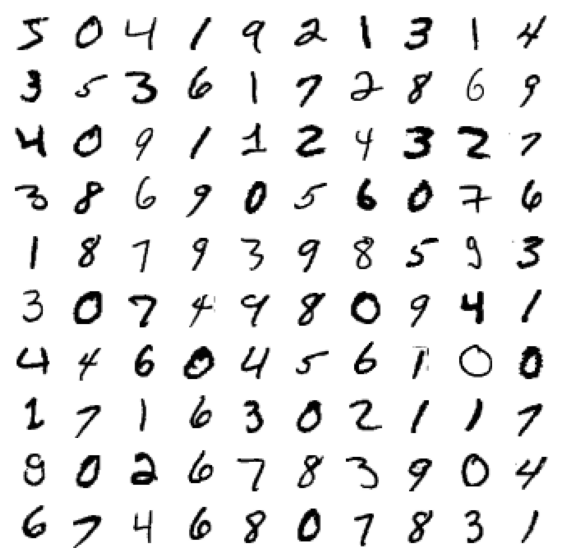

In [5]:
to_image = X[:100]
fig, axes = plt.subplots(10, 10, figsize=(7, 7))
for index, ax in enumerate(axes.flat):
    adjusted_image = to_image[index].reshape(28, 28)
    ax.imshow(adjusted_image, cmap='binary')
    ax.axis('off')

In [6]:
sgd_clf = SGDClassifier(random_state=42)
y_train_5, y_test_5 = (y_train==5), (y_test==5)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [7]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343847


In [9]:
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [10]:
data = X_train[:5]
scores_0 = sgd_clf.decision_function(data)
scores_0

array([  2164.22030239,  -5897.37359354, -13489.14805779,  -4623.84515943,
        -6873.05248453])

In [11]:
threshold = -6000
bool_scores = (scores_0 > threshold)
bool_scores

array([ True,  True, False,  True, False])

In [12]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [13]:
recalls

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00], shape=(60001,))

In [14]:
precisions

array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
       1.        ], shape=(60001,))

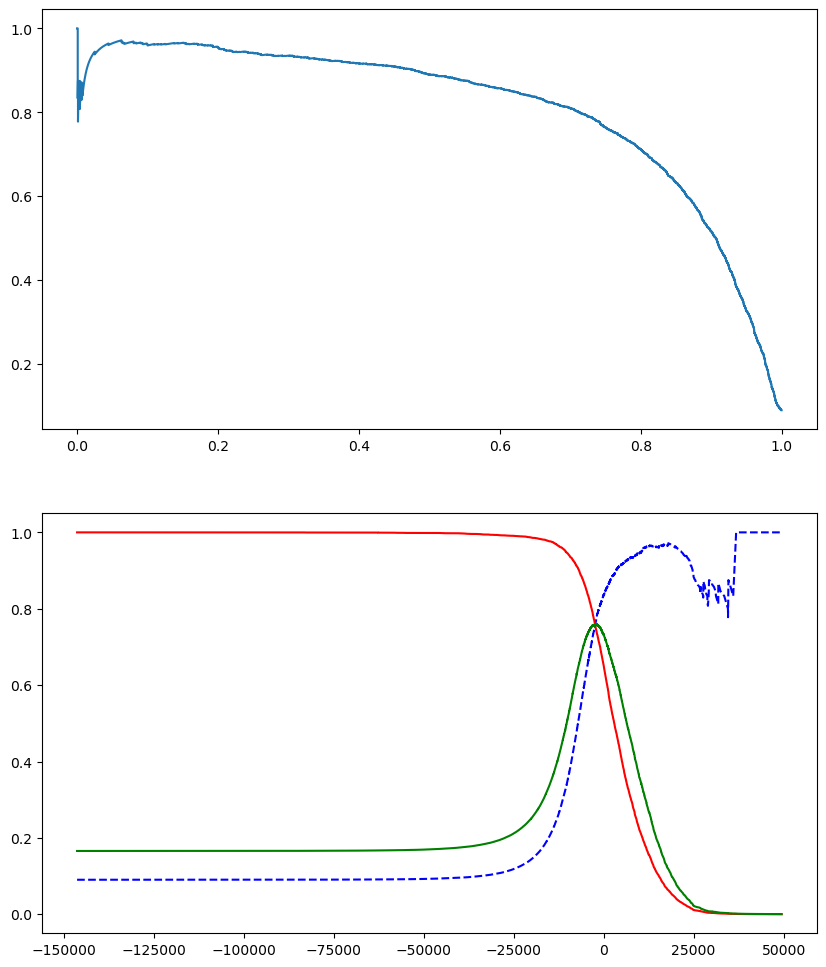

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
axes[0].plot(recalls, precisions)
axes[1].plot(thresholds, precisions[:-1], 'b--')
axes[1].plot(thresholds, recalls[:-1], 'r')
f1 = 2 * (precisions * recalls) / (precisions + recalls)
axes[1].plot(thresholds, f1[:-1], 'g')

In [16]:
best_f1_idx = np.argmax(f1)
best_threshold = thresholds[best_f1_idx]
print(best_threshold)

-1991.7400221488995


In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds  = roc_curve(y_train_5, y_scores)
print(fpr)
print(tpr)

[0.         0.         0.         ... 0.99937705 0.99937705 1.        ]
[0.00000000e+00 1.84467810e-04 9.22339052e-04 ... 9.99815532e-01
 1.00000000e+00 1.00000000e+00]


In [18]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [20]:
y_scores_forest = y_proba_forest[:, 1]

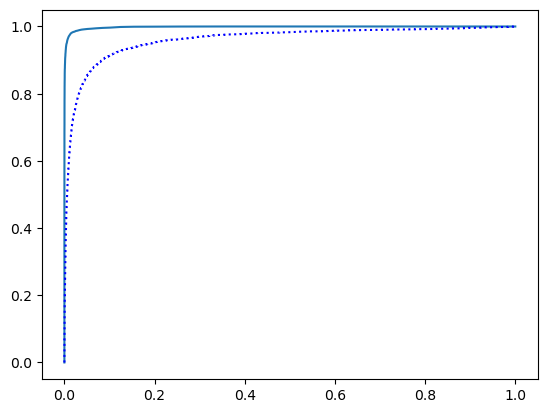

In [21]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr, tpr, 'b:')

In [22]:
y_des_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_des_forest))
print(recall_score(y_train_5, y_des_forest))

0.9905083315756169
0.8662608374838591


In [23]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [26]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

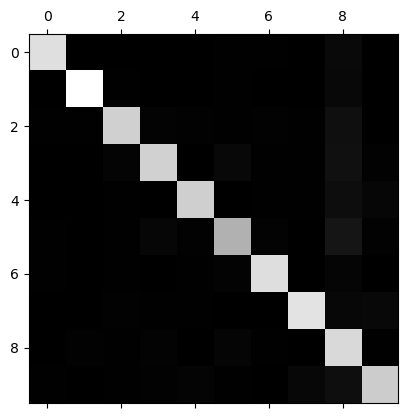

In [31]:
fig, ax = plt.subplots(1, 1)
ax.matshow(conf_mx, cmap=plt.cm.gray)

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

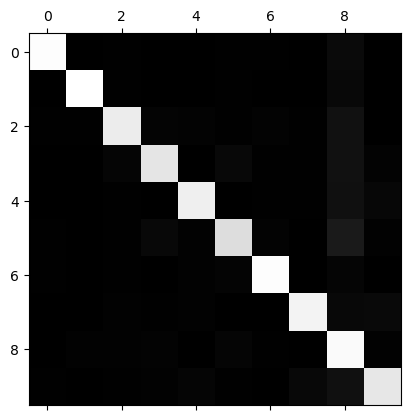

In [39]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

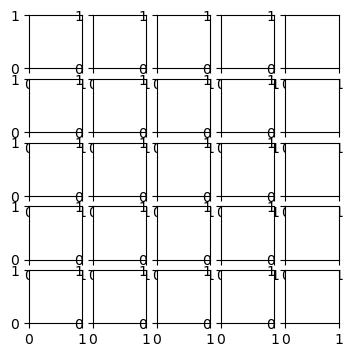

In [ ]:
im_3, im_5 = 3, 5
X_tn = [(y_train==im_3) & (y_train_pred==im_3)]
X_fp = [(y_train==im_3) & (y_train_pred==im_5)]
X_fn = [(y_train==im_5) & (y_train_pred==im_3)]
X_tp = [(y_train==im_5) & (y_train_pred==im_5)]

X_tn_sm, X_fp_mn, X_fn_sm, X_tp_mn = X_tn[:25], X_fp[:25], X_fn[:25], X_tp[:25]

fig, axes = plt.subplots(5, 5 , figsize=(4, 4))

def show_image(axes, images):
    for idx, ax in enumerate(axes.flat):
        adjusted_image = images[idx].reshape(28, 28)
        ax.imshow(adjusted_image)
        ax.axis('off')
show_image()